## LayoutLMv3 Test Notebook

Author: Jackson Guthrie.
Purpose: Classify a form-based long document into various document types using computer vision techniques.

Environment: cv-learning-dev from `environment.yml` in this repo.

In [24]:
from transformers import AutoProcessor, AutoModel
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.stats import contingency
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Suppress warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Load a small sample of RVL-CDIP
dataset = load_dataset("rvl_cdip", split="train[:1000]", trust_remote_code=True)  # Adjust sample size as needed

# Load LayoutLMv3 processor and model
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")

In [5]:
# Feature Extraction Loop (DataFrame Method)
processed_docs = []
hidden_dim = model.config.hidden_size # 768

for idx, doc in enumerate(dataset):
    img = doc["image"] if isinstance(doc, dict) else doc[0]
    if img.mode != "RGB":
        img = img.convert("RGB")
    img_resized = img.resize((1000, 1000))
    encoding = processor(
        images=img,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    with torch.no_grad():
        outputs = model(**encoding, output_attentions=True)
        token_embs = outputs.last_hidden_state[0]
        attn = outputs.attentions[-1][0]  # (num_heads, seq_len, seq_len)
        cls_attn = attn.mean(dim=0).cpu().numpy()[0]

    # --- Create placeholders for features ---
    header_emb = None
    footer_emb = None

    bboxes = encoding["bbox"][0].cpu().numpy()
    header_idxs = [i for i, bbox in enumerate(bboxes) if bbox[1] < 150 and i > 0]
    footer_idxs = [i for i, bbox in enumerate(bboxes) if bbox[3] > 850 and i > 0]

    if header_idxs:
        header_emb = token_embs[header_idxs].mean(dim=0).cpu().numpy()

    if footer_idxs:
        footer_emb = token_embs[footer_idxs].mean(dim=0).cpu().numpy()
    
    # Store all information for the current document in a dictionary
    processed_docs.append({
        'doc_index': idx,
        'true_label': doc['label'],
        'attention_feature': cls_attn,
        'header_feature': header_emb,
        'footer_feature': footer_emb
    })

# Convert the list of records into a Pandas DataFrame
df = pd.DataFrame(processed_docs)

# Now you have a structured table linking every feature to its true label!
print("DataFrame created. Showing the first 5 rows:")
print(df.head())
print(f"\nDataFrame shape: {df.shape}")

DataFrame created. Showing the first 5 rows:
   doc_index  true_label                                  attention_feature  \
0          0          11  [0.0061405357, 0.00029848606, 0.00043402726, 0...   
1          1           5  [0.0047037285, 0.00016830848, 0.00017079506, 0...   
2          2          10  [0.005993871, 0.0007208926, 0.0004997202, 0.00...   
3          3           9  [0.0050104638, 0.0001812312, 0.00016282906, 0....   
4          4           6  [0.0043671816, 0.00016423578, 0.00012125762, 0...   

                                      header_feature  \
0  [-0.041371375, -0.09749903, -0.095450655, -0.0...   
1  [0.07436237, 0.12691727, 0.09620576, 0.0861909...   
2  [0.052529957, 0.10251642, 0.02798012, 0.014047...   
3  [0.0316436, 0.07795864, 0.03350407, 0.03586830...   
4  [0.040927377, -0.1861389, 0.18995921, -0.02379...   

                                      footer_feature  
0  [0.065198034, -0.03258271, -0.21063887, -0.414...  
1  [0.12511356, -0.10657828, -0.1

In [14]:
def calculate_purity(y_true, y_pred):
    """
    Calculates the cluster purity.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted cluster labels.

    Returns:
        float: The purity score.
    """
    # Create a contingency matrix (confusion matrix) between the true and predicted labels
    contingency_matrix = contingency.crosstab(y_pred, y_true)[1]
    
    # Return the sum of the maximum values in each cluster divided by the total number of samples
    return np.sum(np.amax(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

In [19]:
def tune_pca_and_cluster_with_purity(df, feature_cols, true_labels_col, algorithm='kmeans', n_clusters=16):
    """
    Tunes PCA components, runs clustering, and evaluates using both ARI and Purity.
    """
    # --- 1. Prepare Data ---
    clean_df = df.dropna(subset=feature_cols).copy()
    y_true = clean_df[true_labels_col].values

    if len(feature_cols) > 1:
        features_list = [np.vstack(clean_df[col].values) for col in feature_cols]
        X = np.concatenate(features_list, axis=1)
    else:
        X = np.vstack(clean_df[feature_cols[0]].values)

    print(f"--- Tuning PCA for '{algorithm.upper()}' on features: {', '.join(feature_cols)} ---")
    print(f"Processing {len(X)} samples with {X.shape[1]} initial dimensions.")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- 2. Tuning Loop ---
    component_options = [2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
    ari_scores = {}
    purity_scores = {} # Dictionary to store purity scores

    for n in component_options:
        pca = PCA(n_components=n, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        if algorithm == 'kmeans':
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        else:
            model = AgglomerativeClustering(n_clusters=n_clusters)

        predicted_labels = model.fit_predict(X_pca)

        # Calculate and store both ARI and Purity
        ari_score = adjusted_rand_score(y_true, predicted_labels)
        purity_score = calculate_purity(y_true, predicted_labels)
        
        ari_scores[n] = ari_score
        purity_scores[n] = purity_score
        print(f"  n_components = {n:<4} | ARI: {ari_score:.4f} | Purity: {purity_score:.4f}")

    # --- 3. Find and Visualize Best Results ---
    best_n_ari = max(ari_scores, key=ari_scores.get)
    best_ari = ari_scores[best_n_ari]
    
    best_n_purity = max(purity_scores, key=purity_scores.get)
    best_purity = purity_scores[best_n_purity]

    print(f"\nOptimal n_components (by ARI): {best_n_ari} (ARI: {best_ari:.4f})")
    print(f"Optimal n_components (by Purity): {best_n_purity} (Purity: {best_purity:.4f})\n")

    # Plot both metrics
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(component_options, list(ari_scores.values()), marker='o', linestyle='--', label='Adjusted Rand Index (ARI)')
    ax.plot(component_options, list(purity_scores.values()), marker='s', linestyle='-', label='Cluster Purity')
    
    ax.axvline(best_n_ari, color='blue', linestyle=':', label=f'Best ARI ({best_n_ari} components)')
    ax.axvline(best_n_purity, color='red', linestyle=':', label=f'Best Purity ({best_n_purity} components)')
    
    ax.set_title(f'Performance vs. Number of PCA Components ({algorithm.upper()})')
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('Score')
    ax.legend()
    ax.grid(True)
    plt.show()

    return ari_scores, purity_scores


--- Tuning PCA for 'KMEANS' on features: attention_feature ---
Processing 1000 samples with 709 initial dimensions.
  n_components = 2    | ARI: 0.0626 | Purity: 0.2390
  n_components = 5    | ARI: 0.0675 | Purity: 0.2640
  n_components = 10   | ARI: 0.0803 | Purity: 0.2660
  n_components = 15   | ARI: 0.0845 | Purity: 0.2620
  n_components = 20   | ARI: 0.0828 | Purity: 0.2680
  n_components = 30   | ARI: 0.0815 | Purity: 0.2620
  n_components = 40   | ARI: 0.0747 | Purity: 0.2590
  n_components = 50   | ARI: 0.0823 | Purity: 0.2790
  n_components = 75   | ARI: 0.0858 | Purity: 0.2670
  n_components = 100  | ARI: 0.0776 | Purity: 0.2710
  n_components = 150  | ARI: 0.0810 | Purity: 0.2650

Optimal n_components (by ARI): 75 (ARI: 0.0858)
Optimal n_components (by Purity): 50 (Purity: 0.2790)



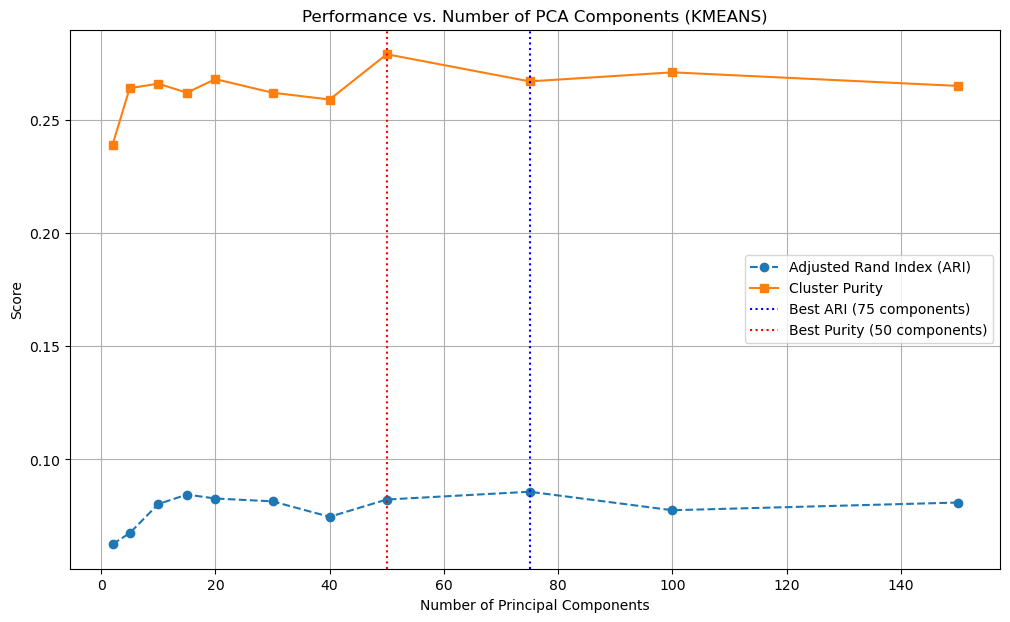

--- Tuning PCA for 'KMEANS' on features: footer_feature ---
Processing 640 samples with 768 initial dimensions.
  n_components = 2    | ARI: 0.0242 | Purity: 0.1906
  n_components = 5    | ARI: 0.0368 | Purity: 0.2266
  n_components = 10   | ARI: 0.0492 | Purity: 0.2484
  n_components = 15   | ARI: 0.0488 | Purity: 0.2469
  n_components = 20   | ARI: 0.0540 | Purity: 0.2516
  n_components = 30   | ARI: 0.0537 | Purity: 0.2437
  n_components = 40   | ARI: 0.0520 | Purity: 0.2500
  n_components = 50   | ARI: 0.0552 | Purity: 0.2469
  n_components = 75   | ARI: 0.0601 | Purity: 0.2469
  n_components = 100  | ARI: 0.0604 | Purity: 0.2609
  n_components = 150  | ARI: 0.0589 | Purity: 0.2625

Optimal n_components (by ARI): 100 (ARI: 0.0604)
Optimal n_components (by Purity): 150 (Purity: 0.2625)



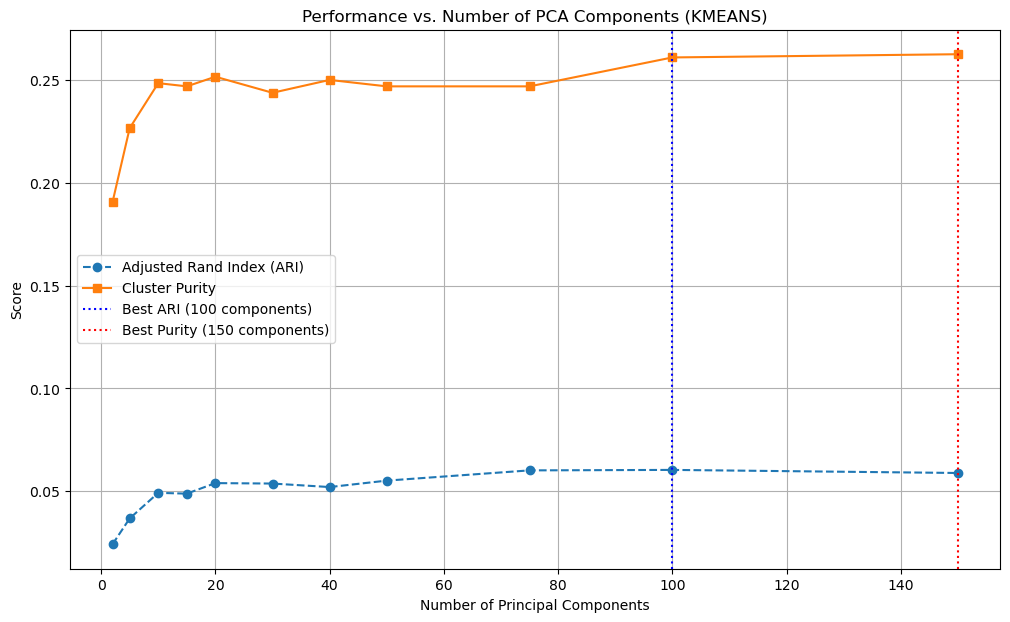

--- Tuning PCA for 'KMEANS' on features: header_feature, attention_feature ---
Processing 1000 samples with 1477 initial dimensions.
  n_components = 2    | ARI: 0.0428 | Purity: 0.2050
  n_components = 5    | ARI: 0.0566 | Purity: 0.2280
  n_components = 10   | ARI: 0.0742 | Purity: 0.2500
  n_components = 15   | ARI: 0.0615 | Purity: 0.2480
  n_components = 20   | ARI: 0.0659 | Purity: 0.2420
  n_components = 30   | ARI: 0.0698 | Purity: 0.2480
  n_components = 40   | ARI: 0.0625 | Purity: 0.2490
  n_components = 50   | ARI: 0.0707 | Purity: 0.2540
  n_components = 75   | ARI: 0.0675 | Purity: 0.2440
  n_components = 100  | ARI: 0.0663 | Purity: 0.2410
  n_components = 150  | ARI: 0.0705 | Purity: 0.2490

Optimal n_components (by ARI): 10 (ARI: 0.0742)
Optimal n_components (by Purity): 50 (Purity: 0.2540)



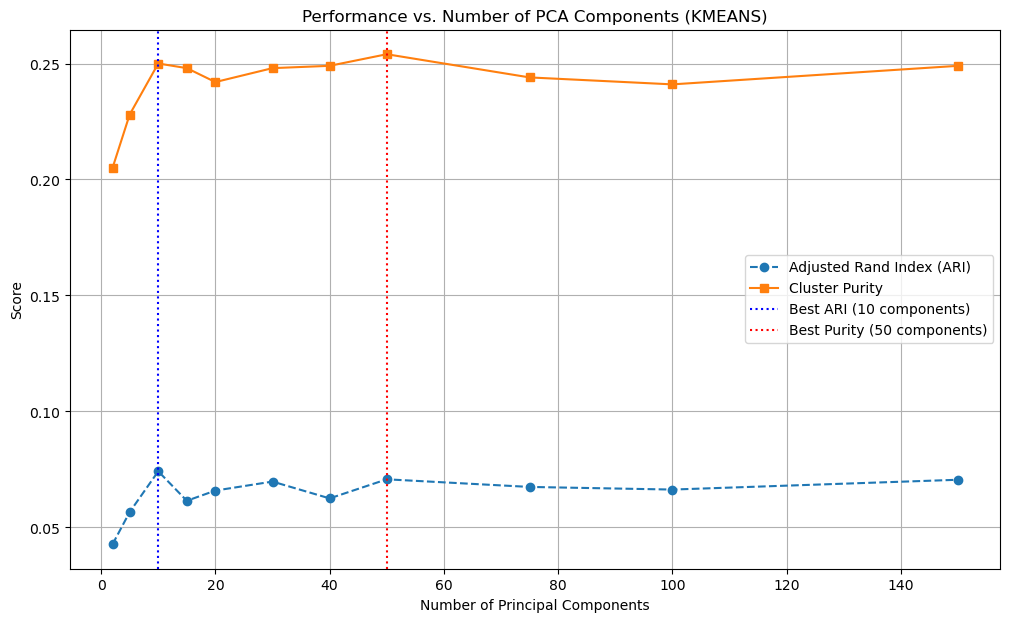

In [20]:
# Tune PCA for Footer Features with K-Means
attn_scores_kmeans = tune_pca_and_cluster_with_purity(
    df=df,
    feature_cols=['attention_feature'],
    true_labels_col='true_label',
    algorithm='kmeans'
)

# Tune PCA for Footer Features with K-Means
footer_scores_kmeans = tune_pca_and_cluster_with_purity(
    df=df,
    feature_cols=['footer_feature'],
    true_labels_col='true_label',
    algorithm='kmeans'
)

# Tune PCA for Concatenated Header and Attention Features with K-Means
header_attn_scores_kmeans = tune_pca_and_cluster_with_purity(
    df=df,
    feature_cols=['header_feature', 'attention_feature'],
    true_labels_col='true_label',
    algorithm='kmeans'
)

### Now......let's used supervised learning 😈

In [22]:
# 1. Prepare Data using Attention Features Only

# Extract the true labels (our target variable, y)
y = df['true_label'].values

# Create the feature matrix (our input, X) using only the attention features
X = np.vstack(df['attention_feature'].values)

# --- 2. Scale Features and Split Data ---

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Feature matrix shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Feature matrix shape: (1000, 709)
Training data shape: (800, 709)
Testing data shape: (200, 709)


In [26]:
# 3. Train a Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model on the attention-feature-based training data
print("Training the SVM classifier...")
svm_classifier.fit(X_train, y_train)
print("Training complete!")

Training the SVM classifier...
Training complete!


In [27]:
# 4. Evaluate the Classifier
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}\n")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 0.3100

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.17      0.15        12
           1       0.33      0.25      0.29        12
           2       0.60      0.69      0.64        13
           3       0.71      0.36      0.48        14
           4       0.40      0.44      0.42         9
           5       0.07      0.09      0.08        11
           6       0.36      0.62      0.46        13
           7       0.33      0.23      0.27        13
           8       0.62      0.77      0.69        13
           9       0.10      0.08      0.09        13
          10       0.36      0.29      0.32        14
          11       0.18      0.17      0.17        12
          12       0.18      0.20      0.19        10
          13       0.00      0.00      0.00        14
          14       0.56      0.38      0.45        13
          15       0.16      0.21      0.18        14

    accuracy                   

#### Now let's change to concatenate the last 4 layers, not just the final layer containing the attention mask

In [28]:
processed_docs_concat = []

for idx, doc in enumerate(dataset):
    # --- (Your image processing and model input preparation remains the same) ---
    img = doc["image"] if isinstance(doc, dict) else doc[0]
    if img.mode != "RGB":
        img = img.convert("RGB")
    encoding = processor(
        images=img, return_tensors="pt", truncation=True, padding="max_length", max_length=512
    )

    # Add output_hidden_states=True to get all layer outputs
    with torch.no_grad():
        outputs = model(**encoding, output_hidden_states=True)

    # outputs.hidden_states is a tuple of all hidden layers' outputs
    # We want to access the last 4 layers
    hidden_states = outputs.hidden_states[-4:]

    # For each of the last 4 layers, get the embedding of the [CLS] token (at index 0)
    cls_embeddings = [
        state[:, 0, :] for state in hidden_states
    ]

    # Concatenate the four [CLS] vectors (4 * 768 = 3072 dimensions)
    concatenated_vector = torch.cat(cls_embeddings, dim=1).cpu().numpy().flatten()

    processed_docs_concat.append({
        'doc_index': idx,
        'true_label': doc['label'],
        'concat_feature': concatenated_vector
    })

# Create a new DataFrame with these powerful features
concat_df = pd.DataFrame(processed_docs_concat)

print("DataFrame with concatenated features created.")
print(f"Shape of a single feature vector: {concat_df['concat_feature'].iloc[0].shape}")

DataFrame with concatenated features created.
Shape of a single feature vector: (3072,)


In [29]:
# 2. Prepare and Split the Data
# Extract the true labels (y)
y = concat_df['true_label'].values

# Create the feature matrix (X) from our new concatenated features
X = np.vstack(concat_df['concat_feature'].values)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Feature matrix shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")


Feature matrix shape: (1000, 3072)
Training data shape: (800, 3072)


In [30]:
# 3. Train the SVM Classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

print("Training the SVM classifier on concatenated layer features...")
svm_classifier.fit(X_train, y_train)
print("Training complete!")

# --- 4. Evaluate the Classifier ---
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Training the SVM classifier on concatenated layer features...
Training complete!

Overall Accuracy: 0.7400

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.50      0.50      0.50        12
           2       0.92      0.92      0.92        13
           3       0.81      0.93      0.87        14
           4       0.75      0.67      0.71         9
           5       0.42      0.45      0.43        11
           6       0.73      0.62      0.67        13
           7       0.75      0.69      0.72        13
           8       0.67      0.77      0.71        13
           9       0.71      0.77      0.74        13
          10       0.69      0.79      0.73        14
          11       0.90      0.75      0.82        12
          12       0.80      0.80      0.80        10
          13       0.73      0.79      0.76        14
          14       1.00      1.00      1.00        13
    

Let's try the last-4 layer method, but unsupervisd.

In [31]:
# 1. Prepare Data for Unsupervised Clustering

# X is our feature matrix, built from the new concatenated features
X_unsupervised = np.vstack(concat_df['concat_feature'].values)

# y is our ground truth for evaluating the clustering quality
y_unsupervised = concat_df['true_label'].values

print(f"Feature matrix shape for clustering: {X_unsupervised.shape}")
print(f"True labels shape for clustering: {y_unsupervised.shape}")

Feature matrix shape for clustering: (1000, 3072)
True labels shape for clustering: (1000,)


--- Tuning PCA for 'KMEANS' on features: concat_feature ---
Processing 1000 samples with 3072 initial dimensions.
  n_components = 2    | ARI: 0.0670 | Purity: 0.2620
  n_components = 5    | ARI: 0.1184 | Purity: 0.3100
  n_components = 10   | ARI: 0.1434 | Purity: 0.3440
  n_components = 15   | ARI: 0.1436 | Purity: 0.3390
  n_components = 20   | ARI: 0.1444 | Purity: 0.3420
  n_components = 30   | ARI: 0.1358 | Purity: 0.3360
  n_components = 40   | ARI: 0.1482 | Purity: 0.3510
  n_components = 50   | ARI: 0.1497 | Purity: 0.3530
  n_components = 75   | ARI: 0.1416 | Purity: 0.3480
  n_components = 100  | ARI: 0.1386 | Purity: 0.3430
  n_components = 150  | ARI: 0.1454 | Purity: 0.3490

Optimal n_components (by ARI): 50 (ARI: 0.1497)
Optimal n_components (by Purity): 50 (Purity: 0.3530)



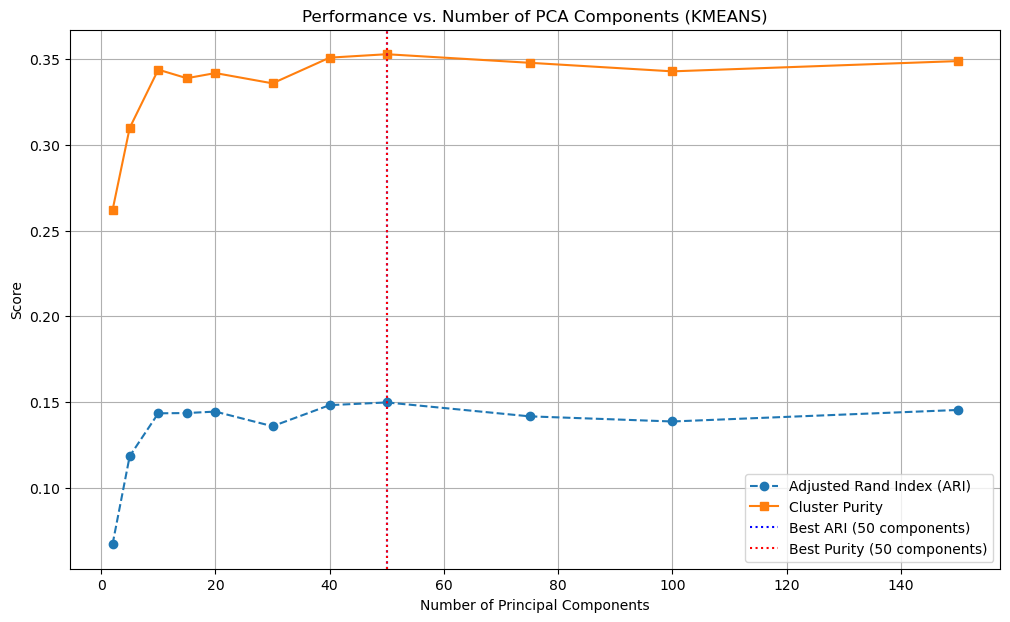

In [32]:
# 2. Run PCA Tuning and Clustering on the New Features

# We can directly use the function we created earlier
# It will loop through PCA components, run KMeans, and report ARI/Purity
ari_results_concat, purity_results_concat = tune_pca_and_cluster_with_purity(
    df=concat_df,
    feature_cols=['concat_feature'], # Use the new feature column
    true_labels_col='true_label',
    algorithm='kmeans',
    n_clusters=16
)